<a href="https://colab.research.google.com/github/d9249/DACON/blob/main/DenseNet161.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Oct 18 00:08:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -uq "/content/drive/MyDrive/DACON_CropsAreSick/sicks.zip"

In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os, json, PIL, cv2, torch, torchvision, warnings
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [5]:
train_total = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [6]:
train_total

,uid,img_path,disease,disease_code
0,10000,train_imgs/10000.jpg,시설포도노균병,1
1,10001,train_imgs/10001.jpg,시설포도노균병,1
2,10002,train_imgs/10002.jpg,시설포도노균병반응,2
3,10003,train_imgs/10003.jpg,축과병,4
4,10004,train_imgs/10004.jpg,시설포도노균병,1
...,...,...,...,...
245,10245,train_imgs/10245.jpg,시설포도노균병반응,2
246,10246,train_imgs/10246.jpg,시설포도탄저병반응,6
247,10247,train_imgs/10247.jpg,시설포도노균병,1
248,10248,train_imgs/10248.jpg,시설포도노균병반응,2


In [7]:
test

,uid,img_path
0,20000,test_imgs/20000.jpg
1,20001,test_imgs/20001.jpg
2,20002,test_imgs/20002.jpg
3,20003,test_imgs/20003.jpg
4,20004,test_imgs/20004.jpg
...,...,...
4745,24745,test_imgs/24745.jpg
4746,24746,test_imgs/24746.jpg
4747,24747,test_imgs/24747.jpg
4748,24748,test_imgs/24748.jpg


In [27]:
device = torch.device("cuda:0")
batch_size = 12
class_n = len(train_total['disease_code'].unique())
lr = 0.0001
epochs = 5
weight_decay = 0.00001
save_path = '/content/drive/MyDrive/DACON_CropsAreSick/DenseNet161_model.pt'

In [73]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        if mode == 'train':
            self.labels = labels
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        if self.mode == 'train':
            img = cv2.imread('./train_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'label' : torch.tensor(self.labels[i], dtype=torch.long)
            }
        else:
            img = cv2.imread('./test_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
            }

In [7]:
def count(output, target):
    with torch.no_grad():
        predict = torch.argmax(output, 1)
        correct = (predict == target).sum().item()
        return correct

def select_model(model, num_classes):
    if model == 'densenet121':
        model_ = models.densenet121(pretrained=True)
        model_.classifier = nn.Linear(1024, num_classes)
    elif model == 'densenet161':
        model_ = models.densenet161(pretrained=True)
        model_.classifier = nn.Linear(2208, num_classes)
    return model_

class Baseline():
    def __init__(self, model, num_classes, gpu_id=0, epoch_print=1, print_freq=10, save=False):
        self.gpu = gpu_id
        self.epoch_print = epoch_print
        self.print_freq = print_freq
        self.save = save

        torch.cuda.set_device(self.gpu)

        self.loss_function = nn.CrossEntropyLoss().cuda(self.gpu)

        model = select_model(model, num_classes)
        self.model = model.cuda(self.gpu)

        self.train_losses, self.test_losses = [], []
        self.train_acc, self.test_acc = [], []
        self.best_acc = None
        self.best_loss = None

    def train(self, train_data, test_data, epochs=100, lr=0.1, weight_decay=0.0001):
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr, weight_decay=weight_decay)
        
        for epoch in range(epochs):
            if epoch % self.epoch_print == 0: print('Epoch {} Started...'.format(epoch+1))
            for i, (X, y) in enumerate(train_data):
                X, y = X.cuda(self.gpu), y.cuda(self.gpu)
                output = self.model(X)
                loss = self.loss_function(output, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (epoch % self.epoch_print == 0) and (i % self.print_freq == 0):
                    train_acc = 100 * count(output, y) / y.size(0)
                    test_acc, test_loss = self.test(test_data)
                    
                    if self.save and ((self.best_acc == None) or (self.best_acc < test_acc) or (test_loss < self.best_loss)):
                        torch.save(self.model.state_dict(), '{}_{}.pt'.format(epoch, i))
                        self.best_acc = test_acc
                        self.best_loss = test_loss
                        print('Best Model Saved')

                    self.train_losses.append(loss.item())
                    self.train_acc.append(train_acc)
                    self.test_losses.append(test_loss)
                    self.test_acc.append(test_acc)

                    print('Iteration : {} - Train Loss : {:.6f}, Test Loss : {:.6f}, '
                          'Train Acc : {:.6f}, Test Acc : {:.6f}'.format(i+1, loss.item(), test_loss, train_acc, test_acc))
            print()

    def test(self, test_data):
        correct, total = 0, 0
        losses = []

        self.model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(test_data):
                X, y = X.cuda(self.gpu), y.cuda(self.gpu)
                output = self.model(X)

                loss = self.loss_function(output, y)
                losses.append(loss.item())
                
                correct += count(output, y)
                total += y.size(0)
        self.model.train()
        return (100*correct/total, sum(losses)/len(losses))

In [8]:
data_dir = './train_imgs/'
imgs, labels = [], []
imgs = data_dir + train_total['img_path'].str.split('/').str[-1].values
labels = train_total['disease_code'].values

label_info = {label:i for i, label in enumerate(sorted(set(labels)))}
train_imgs, val_imgs, train_labels, val_labels = train_test_split(imgs, labels, random_state=0, stratify=labels)

class TrainDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = train_imgs
        self.labels = train_labels
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imgs[idx]).convert('RGB')
        if self.transform: img = self.transform(img)

        label = self.label_info[self.labels[idx]]
        return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'label' : torch.tensor(self.labels[idx], dtype=torch.long)
            }

    def __len__(self):
        return len(self.imgs)
    
class ValDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = val_imgs
        self.labels = val_labels
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imgs[idx]).convert('RGB')
        if self.transform: img = self.transform(img)

        label = self.label_info[self.labels[idx]]
        return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'label' : torch.tensor(self.labels[idx], dtype=torch.long)
            }

    def __len__(self):
        return len(self.imgs)

class TestDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = val_imgs
        # self.labels = val_labels
        # self.label_info = label_info
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imgs[idx]).convert('RGB')
        if self.transform: img = self.transform(img)

        # label = self.label_info[self.labels[idx]]
        return img

    def __len__(self):
        return len(self.imgs)

In [11]:
imgs

array(['./train_imgs/10000.jpg', './train_imgs/10001.jpg',
       './train_imgs/10002.jpg', './train_imgs/10003.jpg',
       './train_imgs/10004.jpg', './train_imgs/10005.jpg',
       './train_imgs/10006.jpg', './train_imgs/10007.jpg',
       './train_imgs/10008.jpg', './train_imgs/10009.jpg',
       './train_imgs/10010.jpg', './train_imgs/10011.jpg',
       './train_imgs/10012.jpg', './train_imgs/10013.jpg',
       './train_imgs/10014.jpg', './train_imgs/10015.jpg',
       './train_imgs/10016.jpg', './train_imgs/10017.jpg',
       './train_imgs/10018.jpg', './train_imgs/10019.jpg',
       './train_imgs/10020.jpg', './train_imgs/10021.jpg',
       './train_imgs/10022.jpg', './train_imgs/10023.jpg',
       './train_imgs/10024.jpg', './train_imgs/10025.jpg',
       './train_imgs/10026.jpg', './train_imgs/10027.jpg',
       './train_imgs/10028.jpg', './train_imgs/10029.jpg',
       './train_imgs/10030.jpg', './train_imgs/10031.jpg',
       './train_imgs/10032.jpg', './train_imgs/10033.jpg

train 200/250 imges

validation 50/250 imges

In [12]:
train = train_total.iloc[:200]
val = train_total.iloc[200:]

In [ ]:
train

In [ ]:
val

In [11]:
print(train_total['img_path'].str.split('/').str[-1].values)

['10000.jpg' '10001.jpg' '10002.jpg' '10003.jpg' '10004.jpg' '10005.jpg'
 '10006.jpg' '10007.jpg' '10008.jpg' '10009.jpg' '10010.jpg' '10011.jpg'
 '10012.jpg' '10013.jpg' '10014.jpg' '10015.jpg' '10016.jpg' '10017.jpg'
 '10018.jpg' '10019.jpg' '10020.jpg' '10021.jpg' '10022.jpg' '10023.jpg'
 '10024.jpg' '10025.jpg' '10026.jpg' '10027.jpg' '10028.jpg' '10029.jpg'
 '10030.jpg' '10031.jpg' '10032.jpg' '10033.jpg' '10034.jpg' '10035.jpg'
 '10036.jpg' '10037.jpg' '10038.jpg' '10039.jpg' '10040.jpg' '10041.jpg'
 '10042.jpg' '10043.jpg' '10044.jpg' '10045.jpg' '10046.jpg' '10047.jpg'
 '10048.jpg' '10049.jpg' '10050.jpg' '10051.jpg' '10052.jpg' '10053.jpg'
 '10054.jpg' '10055.jpg' '10056.jpg' '10057.jpg' '10058.jpg' '10059.jpg'
 '10060.jpg' '10061.jpg' '10062.jpg' '10063.jpg' '10064.jpg' '10065.jpg'
 '10066.jpg' '10067.jpg' '10068.jpg' '10069.jpg' '10070.jpg' '10071.jpg'
 '10072.jpg' '10073.jpg' '10074.jpg' '10075.jpg' '10076.jpg' '10077.jpg'
 '10078.jpg' '10079.jpg' '10080.jpg' '10081.jpg' '1

In [12]:
print(train_total['disease_code'].values)

[1 1 2 4 1 0 0 2 0 5 0 0 0 0 2 3 0 6 1 4 3 5 0 3 0 0 0 2 0 3 1 2 4 2 1 0 0
 4 0 0 0 1 0 0 2 3 0 0 0 0 0 1 0 3 6 4 1 0 0 1 2 0 0 3 0 2 0 0 5 4 0 3 0 0
 2 0 0 1 2 2 3 0 0 0 0 3 2 0 5 0 3 1 1 1 2 3 5 0 5 3 0 0 5 0 0 1 1 1 0 0 2
 0 0 0 5 0 1 5 0 0 1 1 0 0 0 5 1 0 0 4 0 1 0 1 6 4 5 0 0 2 3 0 0 1 1 0 1 2
 1 4 6 3 0 4 0 1 0 0 6 0 0 2 0 0 0 4 0 1 0 6 6 0 3 0 0 1 1 1 2 2 0 4 0 0 4
 1 6 4 1 0 1 0 1 1 0 0 5 2 3 1 0 0 2 3 2 3 0 2 0 2 4 1 4 1 0 0 3 3 0 3 0 0
 0 1 0 3 2 0 6 3 1 0 3 3 0 3 1 0 3 1 2 1 4 0 3 2 6 1 2 2]


In [22]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()])

In [23]:
train_dataset = TrainDataset(transform=train_transform)
val_dataset = ValDataset(transform=val_transform)
test_dataset = TestDataset(transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
train_dataset = CustomDataset(train['img_path'].str.split('/').str[-1].values, train['disease_code'].values)
val_dataset = CustomDataset(val['img_path'].str.split('/').str[-1].values, val['disease_code'].values)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:

test_dataset = CustomDataset(test['img_path'].str.split('/').str[-1], labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

NameError: ignored

In [56]:
test['img_path'].str.split('/').str[-1]

0       20000.jpg
1       20001.jpg
2       20002.jpg
3       20003.jpg
4       20004.jpg
          ...    
4745    24745.jpg
4746    24746.jpg
4747    24747.jpg
4748    24748.jpg
4749    24749.jpg
Name: img_path, Length: 4750, dtype: object

In [24]:
model = Baseline(model='densenet161', num_classes=class_n, print_freq=5, save=True)

In [25]:
model.model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [26]:
model.train(train_loader, val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)

Epoch 1 Started...


AttributeError: ignored

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Model, self).__init__()
        self.model = models.densenet161(pretrained=True)
        self.dropout = nn.Dropout(rate)
        self.output_layer = nn.Linear(in_features=1000, out_features=class_n, bias=True)
    
    def forward(self, inputs):
        output = self.output_layer(self.dropout(self.model(inputs)))
        return output

In [ ]:
model = CNN_Model(class_n).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
            
        return loss

In [ ]:
loss_plot, val_loss_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

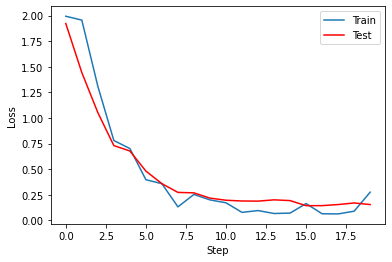

In [42]:
# plt.figure(figsize=(20, 10))
train_lossline, = plt.plot(model.train_losses, label='Train')
test_lossline, = plt.plot(model.test_losses, color='red', label='Test')
plt.legend(handles=[train_lossline, test_lossline])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

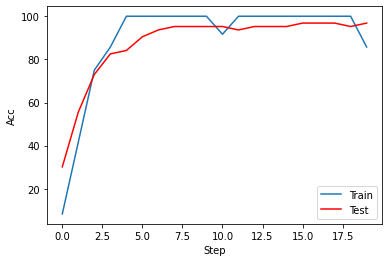

In [44]:
train_accline, = plt.plot(model.train_acc, label='Train')
test_accline, = plt.plot(model.test_acc, color='red', label='Test')
plt.legend(handles=[train_accline, test_accline])
plt.xlabel('Step')
plt.ylabel('Acc')
plt.show()

In [107]:
model = Baseline(model='densenet161', num_classes=class_n)
model.model.load_state_dict(torch.load('./3_15.pt'))

<All keys matched successfully>

In [108]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        with torch.no_grad():
            output = model(img)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

In [115]:
tqdm_dataset = tqdm(enumerate(test_dataloader))
tqdm_dataset


0it [00:00, ?it/s]

In [ ]:
output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()

In [94]:
tqdm_dataset = tqdm(enumerate(test_loader))
training = False
results = []
for batch, test in tqdm_dataset:
  img = test['img_path'].to(device)
  with torch.no_grad():
    output = model(img)
  output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
  results.extend(output)

print(results)

0it [00:01, ?it/s]


IndexError: ignored

In [ ]:
preds = predict(test_loader)

In [88]:
test['img_path'].str.split('/').str[-1]

0       20000.jpg
1       20001.jpg
2       20002.jpg
3       20003.jpg
4       20004.jpg
          ...    
4745    24745.jpg
4746    24746.jpg
4747    24747.jpg
4748    24748.jpg
4749    24749.jpg
Name: img_path, Length: 4750, dtype: object

In [59]:
data_dir = './test_imgs/'

predictions = []
test_dir = test['img_path'].str.split('/').str[-1]
with torch.no_grad():
    for num in sorted(os.listdir(data_dir)):
        with open(data_dir + test_dir, 'r') as j:
            # temp = json.load(j)
            imgs = []
            for info in len(test_dir):
                img_dir = data_dir + test_dir.format(num, info['image_id'])
                img = PIL.Image.open(img_dir).convert('RGB')
                img = test_transform(img)
                imgs.append(img)
            imgs = torch.stack(imgs).cuda()
            prediction = torch.nn.Softmax(dim=1)(model.model(imgs))
            prediction = torch.mean(prediction, dim=0)
            
            # if torch.sum(prediction) != 1: print(torch.sum(prediction))
            predictions.append(prediction.cpu().numpy())

TypeError: ignored

In [65]:
submission = pd.read_csv('./sample_submission.csv')

In [68]:
test_loader

In [89]:
test['img_path'].str.split('/').str[-1]

0       20000.jpg
1       20001.jpg
2       20002.jpg
3       20003.jpg
4       20004.jpg
          ...    
4745    24745.jpg
4746    24746.jpg
4747    24747.jpg
4748    24748.jpg
4749    24749.jpg
Name: img_path, Length: 4750, dtype: object

In [91]:
import numpy as np
mylist = test['img_path'].str.split('/').str[-1]

# for i in range(len(submission)):
    # name =  test['img_path'][i].str.split('/').str[-1]
    # mylist.append(name)

In [105]:
!mkdir test_imgs/none
!mv test_imgs/*.jpg test_imgs/none

In [111]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory('./test_imgs', color_mode='rgb', class_mode='categorical', shuffle=False)

Found 4754 images belonging to 2 classes.


In [113]:
import tensorflow as tf
predict = model.predict(test_loader).argmax(axis=1)

AttributeError: ignored

In [95]:
mylist

0       20000.jpg
1       20001.jpg
2       20002.jpg
3       20003.jpg
4       20004.jpg
          ...    
4745    24745.jpg
4746    24746.jpg
4747    24747.jpg
4748    24748.jpg
4749    24749.jpg
Name: img_path, Length: 4750, dtype: object

In [96]:
submission["predict"] = predict

In [97]:
from collections import Counter

for i in range(len(submission)) :
    predicts = submission.loc[i, ['predict']]
    submission.at[i, 'disease_code'] = Counter(predicts).most_common(n=1)[0][0]

In [98]:
submission = submission[['uid', 'disease_code']]

In [100]:
from google.colab import files

submission.to_csv('./submission_example.csv', index=False)
# files.download('/content/drive/MyDrive/DACON_CVLC/Submission/submission_ensemble_19.csv')

In [109]:
preds = predict(mylist)

AttributeError: ignored

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission.iloc[:,1] = preds
submission.to_csv('DenseNet161_epoch500_batchsize12.csv', index=False)

In [ ]:
from google.colab import files

files.download('DenseNet161_epoch500_batchsize12.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>